In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
    
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [35]:
path = "./data/폭염/S-DoT_NATURE_2022*.csv"

files = glob.glob(path)

df_list = [pd.read_csv(f, encoding='euc-kr') for f in files]

heat_df = pd.concat(df_list, ignore_index=True)

# 서울시 데이터만 필터링
heat_df = heat_df[heat_df['기관 명'] == '서울시']

# 컬럼명 공백 제거
heat_df.columns = heat_df.columns.str.strip()
print(heat_df.columns)
# 필요한 컬럼만 추출
use_cols = ['기관 명', '등록일자', '기온(℃)', '상대습도( %)']

heat_df = heat_df[use_cols]

# 컬럼명 영어로 변경
heat_df.columns = ['agency', 'datetime', 'temp', 'humidity']

# 일시->날짜로 컬럼 추가
heat_df['datetime'] = pd.to_datetime(heat_df['datetime'])
heat_df['date'] = heat_df['datetime'].dt.date

heat_df

Index(['기관 명', '모델명', '시리얼', '구분', '기온(℃)', '상대습도( %)', '풍향(°)', '풍속(m/s)',
       '돌풍 풍향(°)', '돌풍 풍속(m/s)', '조도(lux)', '자외선(UVI)', '소음(dB)', '진동_x(g)',
       '진동_y(g)', '진동_z(g)', '진동_x 최대(g)', '진동_y 최대(g)', '진동_z 최대(g)',
       '흑구 운도(℃)', '전송시간', '등록일자'],
      dtype='object')


,agency,datetime,temp,humidity,date
0,서울시,2022-05-02 00:07:00,13.4,88.0,2022-05-02
1,서울시,2022-05-02 00:07:00,NaN,NaN,2022-05-02
2,서울시,2022-05-02 00:07:00,11.1,100.0,2022-05-02
3,서울시,2022-05-02 00:07:00,12.1,90.0,2022-05-02
4,서울시,2022-05-02 00:07:00,-40.0,65.0,2022-05-02
...,...,...,...,...,...
3297925,서울시,2022-10-02 23:07:00,18.3,87.0,2022-10-02
3297926,서울시,2022-10-02 23:07:00,19.5,84.0,2022-10-02
3297927,서울시,2022-10-02 23:07:00,19.3,86.0,2022-10-02
3297928,서울시,2022-10-02 23:07:00,18.7,85.0,2022-10-02


In [36]:
# 이상치 제거
# 대한민국 기상 관측 이래 가장 높은 최고기온 기록은 41.0℃
heat_df = heat_df[(heat_df['temp'] >= 0) & (heat_df['temp'] <= 41)]
print(heat_df['temp'].min())
print(heat_df['temp'].max())
print(heat_df['temp'].mean())
# 일별 최고기온 계산
daily_max = (
    heat_df
    .groupby('date')
    .agg({
        'temp': 'max',        # 일 최고기온
        'humidity': 'mean'   # 일 평균습도 (보통 mean 추천)
    })
    .reset_index()
)
heat_df = daily_max[(daily_max['temp'] >= 33) & (daily_max['temp'] <= 41)] # 폭염일 기준 온도 33도 이상, 41도 이하

heat_df

0.0
41.0
24.89800594752758


,date,temp,humidity
7,2022-05-09,37.8,51.985741
8,2022-05-10,34.2,32.923616
10,2022-05-12,34.5,47.071351
22,2022-05-25,34.4,56.352499
25,2022-05-28,34.8,50.633605
...,...,...,...
145,2022-09-27,38.5,58.544750
146,2022-09-28,33.5,67.734037
147,2022-09-29,35.4,70.064511
148,2022-09-30,35.9,65.322453


In [37]:
# 미세먼지 데이터
dust_df = pd.read_csv("./data/미세먼지/서울시 대기질 자료 제공_2022.csv", encoding="euc-kr")
dust_df.columns = dust_df.columns.str.strip()

 # 구 단위로 되어 있는거 빼고 평균만 잡기
dust_df = dust_df[dust_df['구분'] == '평균']

dust_df['일시'] = pd.to_datetime(dust_df['일시'])
dust_df['date'] = dust_df['일시'].dt.date
dust_df = (
    dust_df.groupby('date')[['미세먼지(PM10)', '초미세먼지(PM2.5)']].mean().reset_index()
)
dust_df.columns = ['date', 'pm10', 'pm25']
dust_df

,date,pm10,pm25
0,2022-01-01,27.250000,14.708333
1,2022-01-02,34.750000,23.333333
2,2022-01-03,25.291667,14.791667
3,2022-01-04,33.833333,19.541667
4,2022-01-05,47.833333,29.375000
...,...,...,...
360,2022-12-27,49.208333,36.541667
361,2022-12-28,34.500000,21.250000
362,2022-12-29,30.291667,18.375000
363,2022-12-30,38.416667,27.625000


In [38]:
# 폭염 미세먼지 데이터 병합
heat_dust = pd.merge(
    heat_df,
    dust_df
)
heat_dust

heat_df

,date,temp,humidity
7,2022-05-09,37.8,51.985741
8,2022-05-10,34.2,32.923616
10,2022-05-12,34.5,47.071351
22,2022-05-25,34.4,56.352499
25,2022-05-28,34.8,50.633605
...,...,...,...
145,2022-09-27,38.5,58.544750
146,2022-09-28,33.5,67.734037
147,2022-09-29,35.4,70.064511
148,2022-09-30,35.9,65.322453


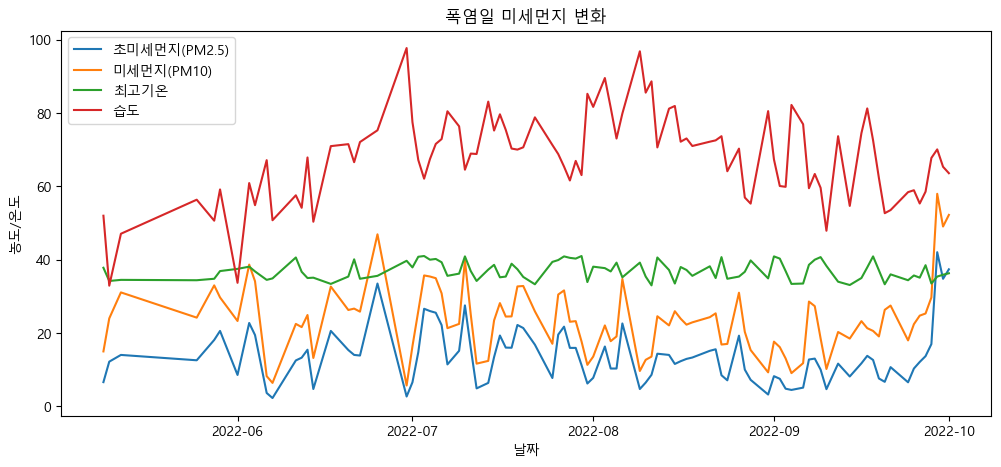

In [39]:
heat_dust = heat_dust.sort_values('date')

plot_df = heat_dust.dropna(subset=['pm25', 'pm10', 'temp', 'humidity'])
plt.figure(figsize=(12,5))
plt.plot(plot_df['date'], plot_df['pm25'], label='초미세먼지(PM2.5)')
plt.plot(plot_df['date'], plot_df['pm10'], label='미세먼지(PM10)')
plt.plot(plot_df['date'], plot_df['temp'], label='최고기온')
plt.plot(plot_df['date'], plot_df['humidity'], label='습도')
plt.title('폭염일 미세먼지 변화')
plt.xlabel('날짜')
plt.ylabel('농도/온도')
plt.legend()
plt.show()

In [42]:
corr = heat_dust[['temp','pm25','pm10', 'humidity']].corr()
print(corr)

              temp      pm25      pm10  humidity
temp      1.000000  0.106948  0.038586 -0.019982
pm25      0.106948  1.000000  0.955595 -0.007764
pm10      0.038586  0.955595  1.000000 -0.164639
humidity -0.019982 -0.007764 -0.164639  1.000000


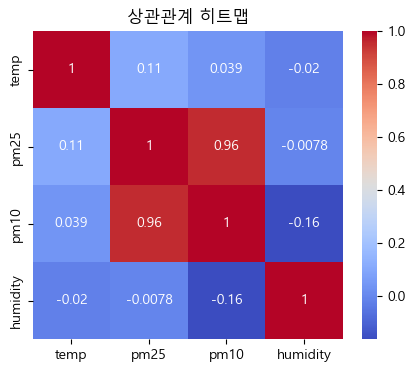

In [43]:
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('상관관계 히트맵')
plt.show()